In [1]:
import torch
import torch.nn 
import numpy as np
import torchvision
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.functional as F

import Servers

In [2]:
import argparse
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name'    , help='experiement name' , type=str     , default='EXPFL')
    parser.add_argument('--model'       , help='model'            , type=str     , default='MLP')
    parser.add_argument('--dataset'     , help='dataset'          , type=str     , default='MNIST')
    parser.add_argument('--optimizer'   , help='optimizer'        , type=str     , default='SGD')
    parser.add_argument('--lr'          , help='learning rate'    , type=float   , default=1e-3)
    parser.add_argument('--decay'       , help='weight decay'     , type=float   , default=1e-4)
    parser.add_argument('--batch_size'  , help='batch size'       , type=int     , default=64)
    parser.add_argument('--seed'        , help='random seed'      , type=int     , default=0)
    parser.add_argument('--epoch'       , help='number of epochs' , type=int     , default=5)
    parser.add_argument('--use_tb'      , help='use tensorboard'  , type=str2bool, default=False)
    ### FL PARAMS ###
    parser.add_argument('--n_clients'   , help='number of clients', type=int     , default=10)
    parser.add_argument('--rounds'      , help='number of clients', type=int     , default=100)
    parser.add_argument('--alpha'       , help='Dirichlet alpha'  , type=float   , default=0.5)
    parser.add_argument('--p_ratio'     , help='Participant ratio', type=float   , default=0.2)
    parser.add_argument('--client'      , help='Client type'      , type=str     , default='NaiveClient')
    parser.add_argument('--aggregator'  , help='Server aggregator', type=str     , default='FedAvg')
    parser.add_argument('--trim_frac'   , help='Trim-mean frac'   , type=float   , default=0.2)
    ### DP PARAMS ###
    parser.add_argument('--defense'     , help='defense'          , type=str     , default='NoDefense')
    parser.add_argument('--epsilon'     , help='epsilon'          , type=float   , default=2.0)
    parser.add_argument('--delta'       , help='delta'            , type=float   , default=1e-2)
    parser.add_argument('--clip_norm'   , help='clip norm'        , type=float   , default=2.0)
    ### GP PARAMS ###
    parser.add_argument('--prune_ratio' , help='pruning ratio'    , type=float   , default=0.9)
    ### ATTACK PARAMS ###
    parser.add_argument('--atk_type'    , help='Attack type'      , type=str     , default='LabelFlip')
    parser.add_argument('--atk_ratio'   , help='Attack ratio'     , type=float   , default=0.2)
    parser.add_argument('--flip'        , help='flip label'       , type=int     , default=1)
    parser.add_argument('--backdoor_opt', help='backdoor option'  , type=str     , default='left')
    parser.add_argument('--backdoor_tar', help='backdoor target'  , type=int     , default=0)
    ### EISFL PARAMS ###
    parser.add_argument('--shuffle'     , help='shuffle'          , type=str2bool, default=False)
    parser.add_argument('--n_val'       , help='# of val samples' , type=int     , default=1)
    args = parser.parse_args([])
    return args
    
def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
    
args = parse_args()

In [4]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
np.set_printoptions(suppress=True, precision=4)
args.n_clients = 50
args.rounds = 1
args.p_ratio = 1.0
args.atk_type = 'Backdoor'
# args.atk_type = 'NoiseAdd'
# args.atk_type = 'LabelFlip'
args.atk_ratio = 0.0
args.alpha = 0.5
args.epoch = 5
args.aggregator = 'FedAvg'
ROUNDS = 1
server = Servers.EISFLServer(args)
threshold = 0.6
for i in range(ROUNDS):
    accs, losses = [], []
    sampled_clients = np.random.choice(range(50), 10, replace=False)
    sampled_clients.sort()
    for idx in sampled_clients:
        server.clients[idx].train()
    val_samples = []
    val_labels  = []
    for idx in tqdm(sampled_clients):
        server.clients[idx].shuffle_weight(round=0)
        val_sample, val_label = server.clients[idx].upload_sample(n_samples=server.args.n_val)
        val_samples.append(val_sample)
        val_labels.append(val_label)
    server.val_samples = torch.cat(val_samples, dim=0)/255
    server.val_labels  = torch.cat(val_labels, dim=0)

    weights = server.integrity_check(sampled_clients)
    server.update_cluster(weights, sampled_clients, threshold=threshold)
    server.clean_cluster()
    for c in sampled_clients:
        print(c, server.user_cluster[c])
    server.aggregate(sampled_clients, weights=weights, args=args)
    server.dispatch()
    for c in server.global_models:
        if c != -1:
            server.global_model.load_state_dict(server.global_models[c].state_dict())
            print(f"CLUSTER {c}")
            server.global_test(i)
            if args.atk_type == 'Backdoor':
                server.backdoor_test(i)
            print('#'*10)
    threshold = min(0.95, threshold * 1.05)

# for idx in tqdm(sampled_clients):
#     server.clients[idx].train()
#     loss, acc = server.clients[idx].test()
# sampled_clients = np.array(sampled_clients)

# val_samples = []
# val_labels  = []
# for idx in tqdm(sampled_clients):
#     server.clients[idx].shuffle_weight(round=0)
#     val_sample, val_label = server.clients[idx].upload_sample(n_samples=server.args.n_val)
#     val_samples.append(val_sample)
#     val_labels.append(val_label)
# val_samples = torch.cat(val_samples, dim=0)/255
# val_labels = torch.cat(val_labels, dim=0)

Experiment: EXPFL|MLP|MNIST|SGD|0.001|0.0001|64|0|5|False|50|1|0.5|1.0|NaiveClient|FedAvg|0.2|2.0|0.01|2.0|Backdoor|0.0|1|left|0|False|1|0.9


100%|██████████| 50/50 [00:00<00:00, 324.34it/s]
0it [00:00, ?it/s]

Initializing 50 clients
50 Benign Clients
0 Backdoor Attack Clients



100%|██████████| 10/10 [00:00<00:00, 420.56it/s]

User 1 belongs to Cluster 0
User 8 belongs to Cluster 0
User 14 belongs to Cluster 0
User 16 belongs to Cluster 0
User 18 belongs to Cluster 0
User 33 belongs to Cluster 0
User 35 belongs to Cluster 0
User 38 belongs to Cluster 0
User 39 belongs to Cluster 0
User 43 belongs to Cluster 0
model keys [-1]
1 0
8 0
14 0
16 0
18 0
33 0
35 0
38 0
39 0
43 0


TypeError: aggregate() takes 2 positional arguments but 4 were given

In [16]:
import torch.nn as nn
def entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1)

sm = nn.Softmax(dim=1)
with torch.no_grad():
    ents_before = []
    for client in sampled_clients[:1]:
        probs = []
        server.clients[client].model.eval()
        for x, y in server.clients[client].testloader:
            o = server.clients[client].model(x)
            p = sm(o)
            probs.append(p)
    probs = np.concatenate(probs, axis=0)
    ent = entropy(probs)
    ents_before.append(ent)
    server.aggregate(sampled_clients, args)
    server.dispatch()
    ents_after = []
    for client in sampled_clients[:1]:
        probs = []
        server.clients[client].model.eval()
        for x, y in server.clients[client].testloader:
            o = server.clients[client].model(x)
            p = sm(o)
            probs.append(p)
    probs = np.concatenate(probs, axis=0)
    ent = entropy(probs)
    ents_after.append(ent)

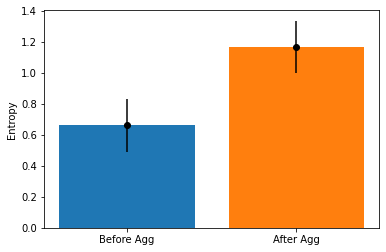

In [29]:
ents_before = np.array(ents_before).flatten()
ents_after = np.array(ents_after).flatten()
plt.bar([0], np.mean(ents_before), label='Before Agg')
plt.bar([1]  , np.mean(ents_after), label='After Agg')
plt.errorbar([0], np.mean(ents_before), np.std(ents_before)/np.sqrt(len(sampled_clients)), fmt='o', color='black')
plt.errorbar([1], np.mean(ents_after), np.std(ents_after)/np.sqrt(len(sampled_clients)), fmt='o', color='black')
plt.ylabel('Entropy')
plt.xticks([0, 1], ['Before Agg', 'After Agg'])
plt.show()

In [ ]:


plt.figure(figsize=(12, 9))
mask = server.user_sim == 0
cmap = mpl.cm.get_cmap('coolwarm')
cmap.set_bad("k")
sns.heatmap(server.user_sim, cmap=cmap, mask=mask)
plt.show()

In [ ]:
sampled_clients = np.random.choice(range(50), 10, replace=False)
sampled_clients.sort()
sampled_clients

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# 클래스 분포 시각화 함수
def visualize_class_distribution(clients):
    for i, client in enumerate(clients):
        # 각 client의 클래스 정보를 추출
        targets = client.trainset.targets
        
        # 클래스별로 카운팅
        unique, counts = np.unique(targets, return_counts=True)
        size_counts = np.zeros(10)
        size_counts[unique] = counts
        plt.scatter(np.arange(0,10), np.ones(10)*i , s=size_counts/2.5)
    plt.ylabel('Client Index')
    plt.xlabel('Class Index')
    plt.tight_layout()
    plt.show()

# 사용 예시
visualize_class_distribution([server.clients[client] for client in sampled_clients])


In [ ]:
g_pred = server.global_model(val_samples)
preds = []
for idx in tqdm(sampled_clients):
    pred = server.clients[idx].model(val_samples)
    preds.append(pred)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# sampled_clients = np.arange(50)
import EAI
MCDO = EAI.MCDropout()
n_bootstrap = 10
print(f'Labels {val_labels}')
entropies = []
with torch.no_grad():
    fig = plt.subplots(figsize=(12,6))
    for cidx, client in enumerate(tqdm(sampled_clients)):
        server.MCDO(server.clients[client].model, val_samples, iter=n_bootstrap)
        # print(f'Client {client} Entropy\n{np.round(server.MCDO.entropy, 4)}')
        entropies.append(server.MCDO.entropy)
        plt.scatter(np.arange(10), np.ones(10)*cidx, s=server.MCDO.entropy*150)
        # print(f'{np.round(server.MCDO.entropy, 4)-np.mean(server.MCDO.entropy)}')
        # print(f'Client {client} Probs\n{np.round(server.MCDO.mean_probs, 4)}')
        server.MCDO.reset()
    plt.xticks(np.arange(10), val_labels.numpy())
    plt.yticks(np.arange(len(sampled_clients)), sampled_clients)
    plt.show()
entropies = np.array(entropies)

In [ ]:
import torch.nn as nn

embedded_samples = []

with torch.no_grad():
    # fig = plt.subplots(figsize=(12,6))
    for client in tqdm(sampled_clients):
        server.clients[client].model.eval()
        outputs = server.clients[client].model(val_samples)
        embedded_samples.append(outputs[None,:])
    embedded_samples = torch.cat(embedded_samples)

    N = sampled_clients.shape[0]
    # M = args.n_val * N
    M = 10
    cosine_sim_matrices = torch.ones(M, N)# torch.ones(M+1, N+1)
    cosine_sim_matrices = torch.diag_embed(cosine_sim_matrices)
    for sidx in range(M):
        for i in range(N):
            for j in range(i + 1, N):
                sim_val = F.cosine_similarity(embedded_samples[i, sidx].unsqueeze(0), embedded_samples[j, sidx].unsqueeze(0))
                cosine_sim_matrices[sidx, i, j] = sim_val
                cosine_sim_matrices[sidx, j, i] = sim_val
        # cosine_sim_matrices[sidx, N, :-1] = torch.FloatTensor(entropies[:, sidx])
        # cosine_sim_matrices[sidx, :-1, N] = torch.FloatTensor(entropies[:, sidx])

In [ ]:
naive_mean_cos_sim = np.mean(cosine_sim_matrices.numpy(), axis=0)
# plt.figure(figsize=(15,15))
sns.heatmap(naive_mean_cos_sim, cmap='coolwarm', annot=True, vmin=-0.5, vmax=1.0)
plt.xticks(np.arange(sampled_clients.shape[0]), sampled_clients)
plt.yticks(np.arange(sampled_clients.shape[0]), sampled_clients)
plt.show()

In [ ]:
def calculate_mean_cosine_similarity(cosine_sim_mat, entropies, entropy_threshold):
    N, M, _ = cosine_sim_mat.shape  # N: 샘플 개수, M: 모델 개수
    mean_cos_sim_mat = np.ones((M, M))  # 평균 유사도를 저장할 행렬 초기화
    valid_idx_lst = []
    for i in range(N):  # 각 샘플에 대해 반복
        # i번째 샘플의 각 모델에 대한 엔트로피 값이 threshold보다 낮은지 확인
        valid_indices = entropies[:, i] < entropy_threshold # 낮은 경우 True, 높은 경우 False
        valid_idx_lst.append(valid_indices)
    valid_idx_lst = np.array(valid_idx_lst)
    for i in range(M):
         for j in range(i+1, M):
            valid_indices = valid_idx_lst[:,i]&valid_idx_lst[:,j]
            # 유효한 모델들의 유사도만 평균 계산
            if np.sum(valid_indices) > 0:  # 유효한 모델이 있는 경우에만 처리
                mean_cos_sim_mat[i, j] = np.mean(cosine_sim_mat[valid_indices, i,j].numpy(), axis=0)
                mean_cos_sim_mat[j, i] = np.mean(cosine_sim_mat[valid_indices, i,j].numpy(), axis=0)
            else:
                mean_cos_sim_mat[i, j] = -1
                mean_cos_sim_mat[j, i] = -1
    return mean_cos_sim_mat

# entropies에는 모델, 샘플 순서로 들어 있음
# 각 모델별로 
entropy_threshold = 1.0
mean_cos_sim_mat = calculate_mean_cosine_similarity(cosine_sim_matrices, entropies, entropy_threshold)
sns.heatmap(mean_cos_sim_mat, cmap='coolwarm', annot=True, vmin=-0.5, vmax=1.0)
plt.xticks(np.arange(sampled_clients.shape[0]), sampled_clients)
plt.yticks(np.arange(sampled_clients.shape[0]), sampled_clients)
plt.show()


In [ ]:
sns.heatmap(entropies, cmap='coolwarm', annot=True)
plt.xticks(np.arange(sampled_clients.shape[0]), val_labels.numpy())
plt.yticks(np.arange(sampled_clients.shape[0]), sampled_clients)
plt.show()

In [ ]:
cluster_set = []
plt.figure(figsize=(12,6))
for i in server.user_cluster:
    cluster_set.append(server.user_cluster[i])
cluster_set = set(cluster_set)
lens = {c:idx for idx, c in enumerate(cluster_set)}

for i, idx in enumerate(server.user_cluster):
    c = 'blue' if i < args.n_clients-int(args.n_clients*args.atk_ratio) else 'red'
    plt.scatter(i, lens[server.user_cluster[i]], color=c, s=100)

cluster_set = set(cluster_set)
print(list(cluster_set))
plt.xticks(np.arange(50))
plt.yticks(range(len(cluster_set)), list(cluster_set))
plt.show()

In [13]:
sampled_clients = np.array(list(range(35,45)))
for client in sampled_clients:
    server.clients[client].model.load_state_dict(server.global_models[0].state_dict())
    server.clients[client].train()

In [ ]:
sampled_clients = np.array(list(range(30,35))+list(range(45,50)))
val_samples = []
val_labels  = []
for idx in tqdm(sampled_clients):
    server.clients[idx].shuffle_weight(round=0)
    val_sample, val_label = server.clients[idx].upload_sample(n_samples=server.args.n_val)
    val_samples.append(val_sample)
    val_labels.append(val_label)
val_samples = torch.cat(val_samples, dim=0)/255
val_labels = torch.cat(val_labels, dim=0)
server.val_samples = val_samples
server.val_labels  = val_labels

weights = server.integrity_check(sampled_clients)
sns.heatmap(weights, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.xticks(np.arange(10), sampled_clients)
plt.yticks(np.arange(10), sampled_clients) 
plt.show()

In [1]:
import os
import torch
import pickle
import numpy as np
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

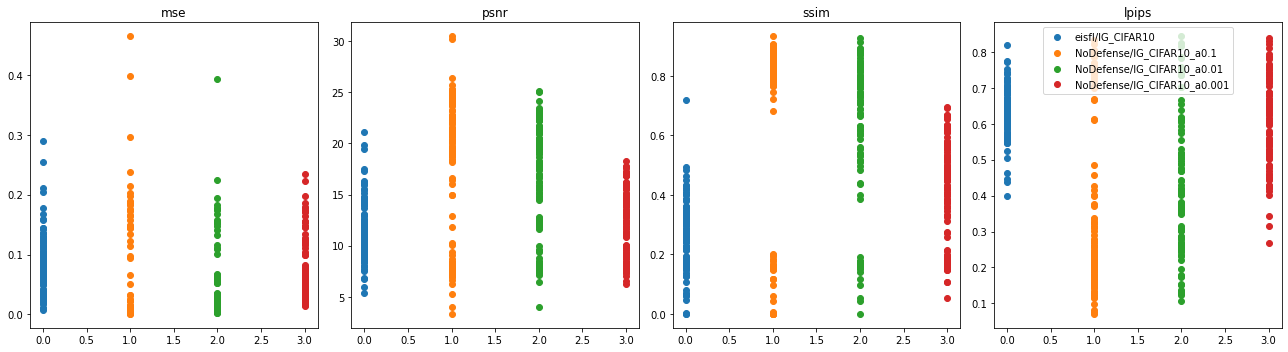

In [5]:
defenses = ['eisfl/IG_CIFAR10', 'NoDefense/IG_CIFAR10_a0.1', 'NoDefense/IG_CIFAR10_a0.01','NoDefense/IG_CIFAR10_a0.001'] # , 'GradPrune_0.5', 'GradPrune_0.7', 'GradPrune_0.75', 'GradPrune_0.9', 'GradPrune_0.99', 'GradPrune_0.999', 'eisfl']
files = [f'./results/{d}/result.pickle' for d in defenses] 

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for fidx, file in enumerate(files):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    for idx, k in enumerate(data.keys()):    
        axes[idx].scatter(np.ones(len(data[k]))*fidx, data[k], label=defenses[fidx])
        # axes[idx].scatter([0], np.mean(data[k]), label=defenses[fidx], s=100)
        axes[idx].set_title(f'{k}')
plt.legend()
plt.tight_layout()
plt.show()

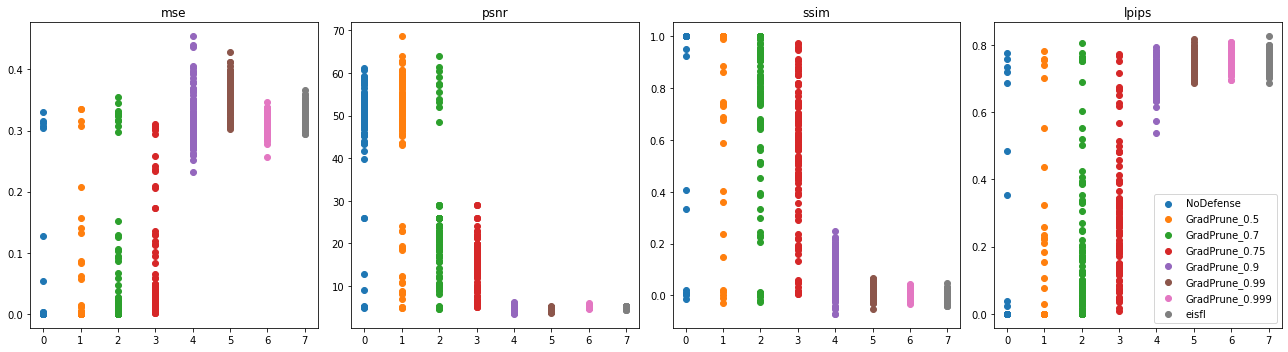

In [2]:
defenses = ['NoDefense', 'GradPrune_0.5', 'GradPrune_0.7', 'GradPrune_0.75', 'GradPrune_0.9', 'GradPrune_0.99', 'GradPrune_0.999', 'eisfl']
files = [f'./results/{d}/IG/result.pickle' for d in defenses] 

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for fidx, file in enumerate(files):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    for idx, k in enumerate(data.keys()):    
        axes[idx].scatter(np.ones(len(data[k]))*fidx, data[k], label=defenses[fidx])
        # axes[idx].scatter([0], np.mean(data[k]), label=defenses[fidx], s=100)
        axes[idx].set_title(f'{k}')
plt.legend()
plt.tight_layout()
plt.show()

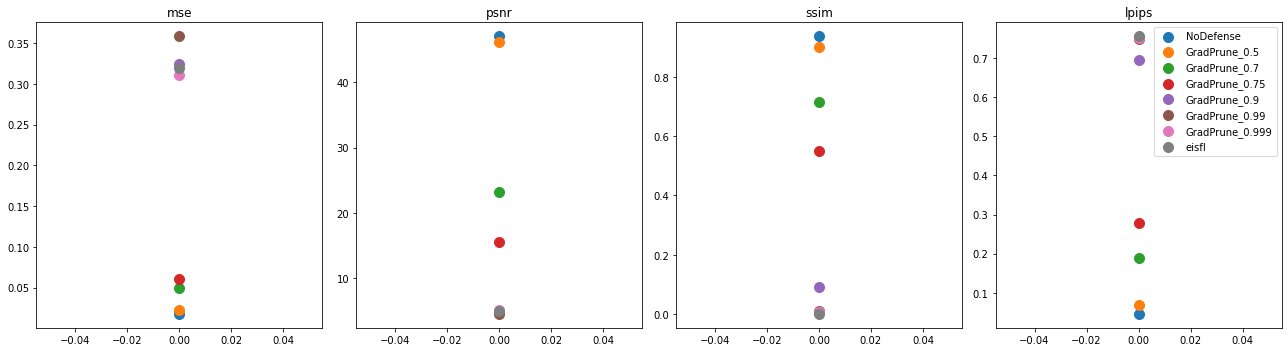

In [3]:
defenses = ['NoDefense', 'GradPrune_0.5', 'GradPrune_0.7', 'GradPrune_0.75', 'GradPrune_0.9', 'GradPrune_0.99', 'GradPrune_0.999', 'eisfl']
files = [f'./results/{d}/IG/result.pickle' for d in defenses] 

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for fidx, file in enumerate(files):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    for idx, k in enumerate(data.keys()):    
        # axes[idx].scatter(np.ones(len(data[k]))*idx, data[k], label=defenses[fidx])
        axes[idx].scatter([0], np.mean(data[k]), label=defenses[fidx], s=100)
        axes[idx].set_title(f'{k}')
plt.legend()
plt.tight_layout()
plt.show()

NoDefense 2.0179757029836765e-06
GradPrune_0.5 6.97184646014648e-07
GradPrune_0.7 3.0876128676027292e-06
GradPrune_0.75 0.009944837540388107
GradPrune_0.9 0.5384798049926758
GradPrune_0.99 0.6867202520370483
GradPrune_0.999 0.6957250833511353
eisfl 0.6870802640914917


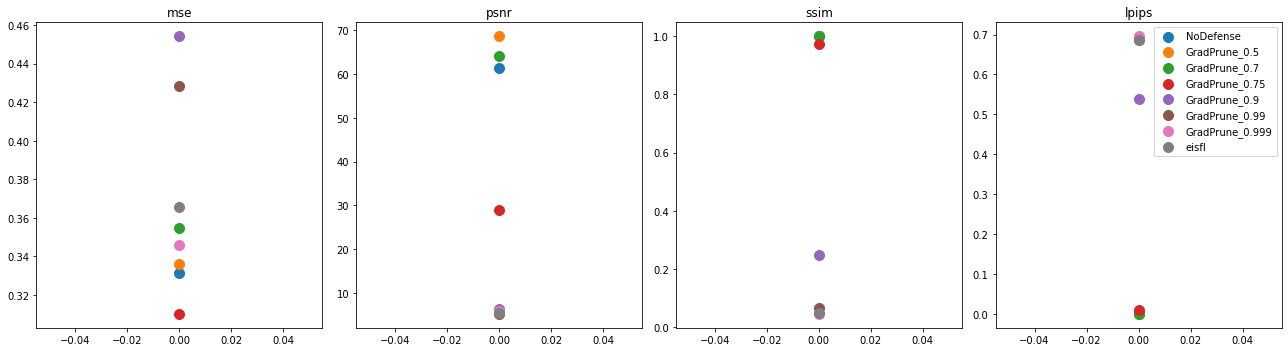

In [7]:
defenses = ['NoDefense', 'GradPrune_0.5', 'GradPrune_0.7', 'GradPrune_0.75', 'GradPrune_0.9', 'GradPrune_0.99', 'GradPrune_0.999', 'eisfl']
files = [f'./results/{d}/IG/result.pickle' for d in defenses] 

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for fidx, file in enumerate(files):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    for idx, k in enumerate(data.keys()):    
        # axes[idx].scatter(np.ones(len(data[k]))*idx, data[k], label=defenses[fidx])
        if k in ['lpips']:
            axes[idx].scatter([0], np.min(data[k]), label=defenses[fidx], s=100)
            print(defenses[fidx], np.min(data[k]))
        else:
            axes[idx].scatter([0], np.max(data[k]), label=defenses[fidx], s=100)
        axes[idx].set_title(f'{k}')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import time
import tracemalloc
torch.manual_seed(args.seed)
np.random.seed(args.seed)
np.set_printoptions(suppress=True, precision=4)
args.n_clients = 50
args.rounds = 1
args.p_ratio = 1.0
args.atk_type = 'Backdoor'
# args.atk_type = 'NoiseAdd'
# args.atk_type = 'LabelFlip'
args.atk_ratio = 0.0
args.alpha = 0.5
args.epoch = 5
args.aggregator = 'FedAvg'
args.defense = 'NoDefense'
ROUNDS = 1
server = Servers.EISFLServer(args)
threshold = 0.6
peak_mem_usages = []
elapsed_times   = [] 
for i in range(ROUNDS):
    accs, losses = [], []
    # sampled_clients = np.random.choice(range(50), 10, replace=False)
    # sampled_clients.sort()
    for idx in tqdm(range(50)):
        start = time.process_time()
        tracemalloc.start()
        server.clients[idx].device = 'cpu'
        server.clients[idx].train()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end = time.process_time()
        elapsed_times.append(end-start)
        peak_mem_usages.append(peak)
        # print(f"Current memory usage: {current / 10**6} MB")
        # print(f"Peak memory usage: {peak / 10**6} MB")
        # print(f"Elapsed time: {end-start} s")

Experiment: EXPFL|MLP|MNIST|SGD|0.001|0.0001|64|0|5|False|50|1|0.5|1.0|NaiveClient|FedAvg|0.2|2.0|0.01|2.0|NoDefense|Backdoor|0.0|1|left|0|False|1|0.9


 38%|███▊      | 19/50 [00:00<00:00, 187.90it/s]

Initializing 50 clients
50 Benign Clients
0 Backdoor Attack Clients


100%|██████████| 50/50 [00:00<00:00, 204.34it/s]
0it [00:00, ?it/s]
100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


In [6]:
import seaborn as sns

print(f"Peak memory usage: {np.mean(peak_mem_usages)/10**6} MB")
print(f"Elapsed time: {np.mean(elapsed_times)} s")

Peak memory usage: 1.9956118600000001 MB
Elapsed time: 21.643057326800008 s


In [17]:
import time
import tracemalloc
torch.manual_seed(args.seed)
np.random.seed(args.seed)
np.set_printoptions(suppress=True, precision=4)
args.n_clients = 50
args.rounds = 1
args.p_ratio = 1.0
args.atk_type = 'Backdoor'
# args.atk_type = 'NoiseAdd'
# args.atk_type = 'LabelFlip'
args.atk_ratio = 0.0
args.alpha = 0.5
args.epoch = 5
args.aggregator = 'FedAvg'
args.defense = 'GradPrune'
ROUNDS = 1
server = Servers.EISFLServer(args)
threshold = 0.6
peak_mem_usages = []
elapsed_times   = [] 
for i in range(ROUNDS):
    accs, losses = [], []
    # sampled_clients = np.random.choice(range(50), 10, replace=False)
    # sampled_clients.sort()
    for idx in tqdm(range(50)):
        start = time.process_time()
        tracemalloc.start()
        server.clients[idx].device = 'cpu'
        server.clients[idx].train()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end = time.process_time()
        elapsed_times.append(end-start)
        peak_mem_usages.append(peak)
        # print(f"Current memory usage: {current / 10**6} MB")
        # print(f"Peak memory usage: {peak / 10**6} MB")
        # print(f"Elapsed time: {end-start} s")

Experiment: EXPFL|MLP|MNIST|SGD|0.001|0.0001|64|0|5|False|50|1|0.5|1.0|NaiveClient|FedAvg|0.2|2.0|0.01|2.0|GradPrune|Backdoor|0.0|1|left|0|False|1|0.9


100%|██████████| 50/50 [00:00<00:00, 304.45it/s]
0it [00:00, ?it/s]

Initializing 50 clients
50 Benign Clients
0 Backdoor Attack Clients


In [18]:
print(f"Peak memory usage: {np.mean(peak_mem_usages)/10**6} MB")
print(f"Elapsed time: {np.mean(elapsed_times)} s")

Peak memory usage: 0.11363962 MB
Elapsed time: 1.0562524696000017 s


In [20]:
1.0562524696000017/0.9484614456399995

1.1136482926696798

In [21]:
0.11363962/0.11422075999999999

0.9949121333109674

<ipython-input-90-bf78b8c9063b>:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20").copy()
  cmap.set_bad("black")
findfont: Font family ['Hevetica Neue'] not found. Falling back to DejaVu Sans.


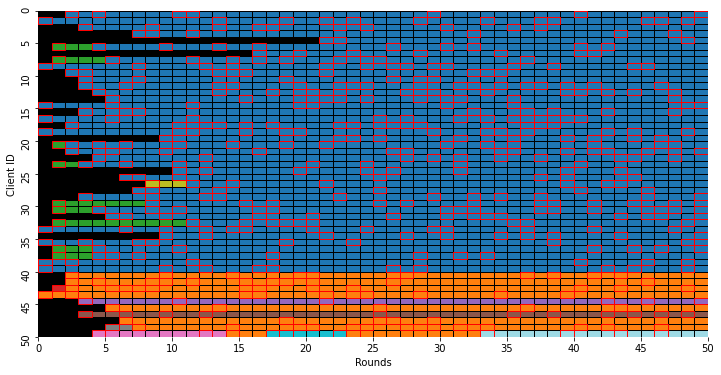

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Hevetica Neue'

selection_history = np.load('./figure/selection_history.npy').reshape(50,10)
cluster_history = np.load('./figure/cluster_history_.npy')
cmap = mpl.cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(12, 6))
cmap.set_bad("black")
# plt.imshow(cluster_history, cmap=colors, aspect='auto')  # 컬러맵 선택
mask = cluster_history == -1
sns.heatmap(cluster_history, cmap=cmap, annot=False, cbar=False, mask=mask)

for i in range(cluster_history.shape[0]):
    for j in range(cluster_history.shape[1]):
        # 셀 위치 계산
        rect = plt.Rectangle(
            (j, i), 1, 1,  # 위치
            fill=False,
            edgecolor="black",  # 테두리 색상
            linewidth=1  # 테두리 두께
        )
        ax.add_patch(rect)
for i in range(cluster_history.shape[0]):
    for j in range(cluster_history.shape[1]):
        # 셀 위치 계산
        if i in selection_history[j]:
            rect = plt.Rectangle(
                (j, i), 1, 1,  # 위치
                fill=False,
                edgecolor="red",  # 테두리 색상
                linewidth=1  # 테두리 두께
            )
            ax.add_patch(rect)
# for x, y_values in enumerate(selection_history):
#     # 선택된 y값 표시
#     ax.scatter([x] * len(y_values), y_values, color="blue", alpha=0, s=50, zorder=2)

#     # 빨간색 네모 테두리 추가
#     ymin, ymax = min(y_values), max(y_values)
#     rect = Rectangle(
#         (x - 0.4, ymin - 0.5),  # 네모의 좌측 하단 좌표
#         0.8,  # 네모의 폭
#         ymax - ymin + 1,  # 네모의 높이
#         edgecolor="red", 
#         facecolor="none",
#         linewidth=2,
#         zorder=1
#     )
#     ax.add_patch(rect)

plt.xticks(np.linspace(0,50,11), np.linspace(0,50,11).astype(int))
plt.yticks(np.linspace(0,50,11), np.linspace(0,50,11).astype(int))
plt.xlabel("Rounds")
plt.ylabel("Client ID")
plt.show()